# Part 2 Google+ Network

In [3]:
library(pracma)
#install.packages("igraph", type="binary")
library(igraph)


Attaching package: ‘igraph’

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



## Helper Functions

In [10]:
# Create Graph Functions
createNetwork = function(ego.label) {
    graph <- read.graph(paste("./gplus/", ego.label, ".edges", sep=""), 
                        format="ncol", directed=TRUE) %>%
            add.vertices(nv=1, name=ego.label)
    
    len <- length(V(graph))-1
    ego.id <- len + 1
    edges_to_add <- unlist(mapply(c, rep(ego.id, len), seq(1, len), SIMPLIFY=FALSE))
    graph <- add.edges(graph, edges_to_add)
    graph
}


# Compute Homegeneity and Completeness
compute_HC = function(selected_id, communities) {
    
    # Read Circles from .circles file
    circleFile <- scan(file=paste("./gplus/", selected_id, ".circles",sep=""), what="", sep="\n");
    circles <- strsplit(circleFile, "[[:space:]]+");
    names(circles) <- sapply(circles, function(x) x[[1]])
    circles <- lapply(circles, function(x) x[-1])
                      
    # Membership
    total_membership <- membership(communities)
    
    # Sizes for All Circles and Communities
    circle_sizes <- sapply(circles, function(x) length(x)) # ai
    community_sizes <- sizes(communities) # This is NOT bj, including nodes without circle info
    
    # Number of Nodes with Circle Information
    nodes_with_circle <- unique(as.character(unlist(circles)))
    N <- length(nodes_with_circle) 
        
    # Sizes for Communities with Circle Info
    circle_communities <- lapply(groups(communities), function(x) intersect(x, nodes_with_circle))
    circle_community_sizes <- sapply(circle_communities, function(x) length(x)) #bj
                                     
    # Number of Circles and Communities
    n_circles <- length(circles)
    n_communities <- length(communities)
    
    # Eliminate Zeroes
    non_zero_community <- circle_community_sizes[circle_community_sizes != 0]    
    
    # Construct Cij Matrix
    C_Matrix <- c()
    for (i in seq(1, n_circles)) {
        cur_circle <- circles[[i]]
        cur_circle_communities <- lapply(groups(communities), function(x) intersect(x, as.character(cur_circle)))
        community_vector <- sapply(cur_circle_communities, function(x) length(x))
        C_Matrix <- cbind(C_Matrix, community_vector)
    }                  
    
    # Compute H(C) and H(K)
    H.C <- -sum(circle_sizes/N * log(circle_sizes/N))
    H.K <- -sum(non_zero_community/N * log(non_zero_community/N))
                           
    # Compute H(C|K) and H(K|C) 
    H.C.K <- 0
    H.K.C <- 0
    for (j in seq(1, n_communities)) {
        for (i in seq(1, n_circles)) {
            if (C_Matrix[j, i] == 0) {
                next
            }
            H.C.K = H.C.K + C_Matrix[j, i]/N * log(C_Matrix[j, i]/circle_community_sizes[j])
            H.K.C = H.K.C + C_Matrix[j, i]/N * log(C_Matrix[j, i]/circle_sizes[i])
        }
    }
    H.C.K = -H.C.K
    H.K.C = -H.K.C
    
    # Compute Homogeneity h and Completeness c
    h <- 1 - H.C.K / H.C
    c <- 1 - H.K.C / H.K
    returnResult <- c(h,c)
    names(returnResult) <- c("h", "c")
    returnResult
}
                      

## Preprocess

[1] "Total Number of Ego Nodes is 132"
[1] "Number of Nodes with more than 2 circles is 57"


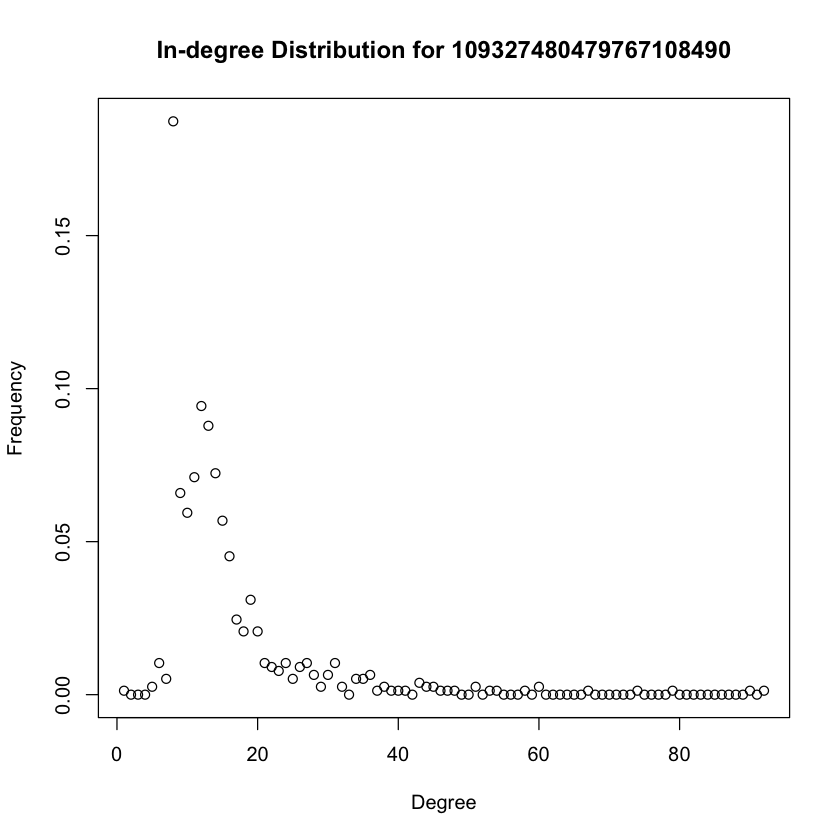

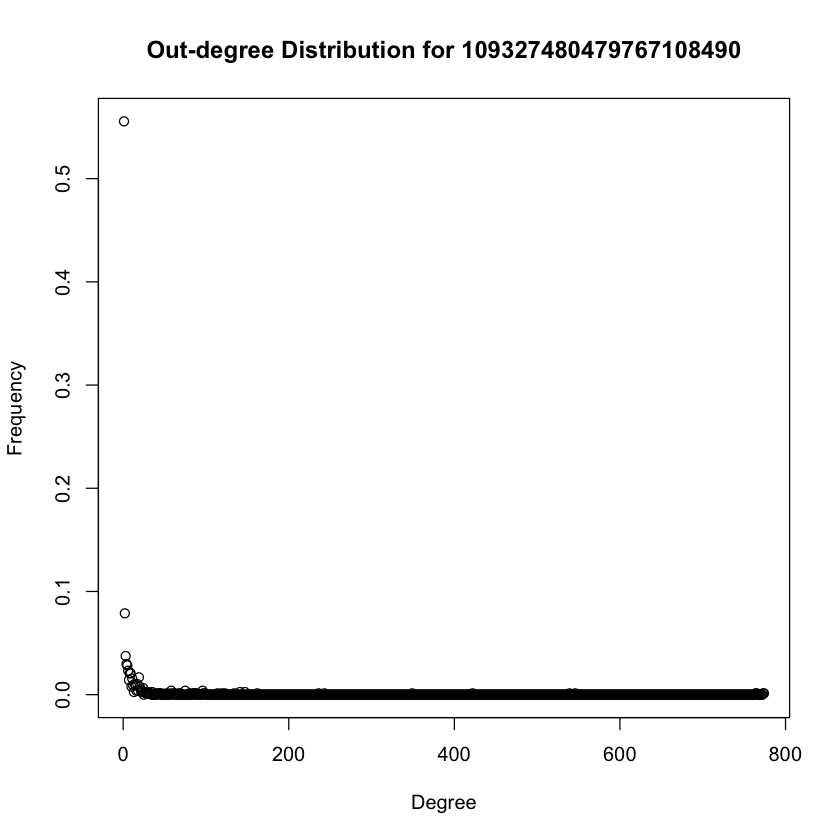

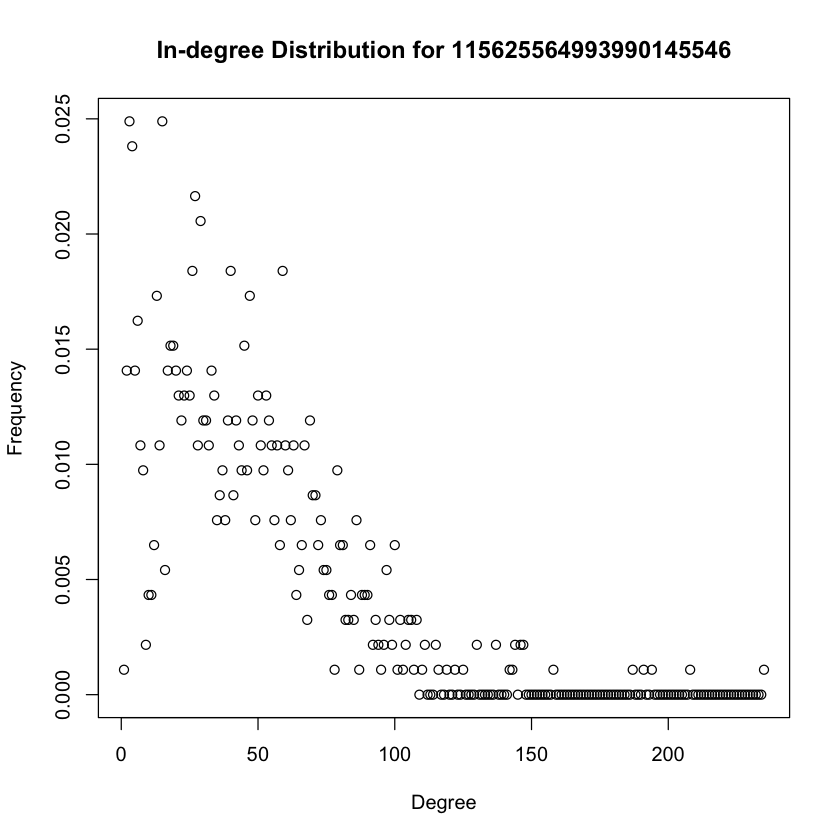

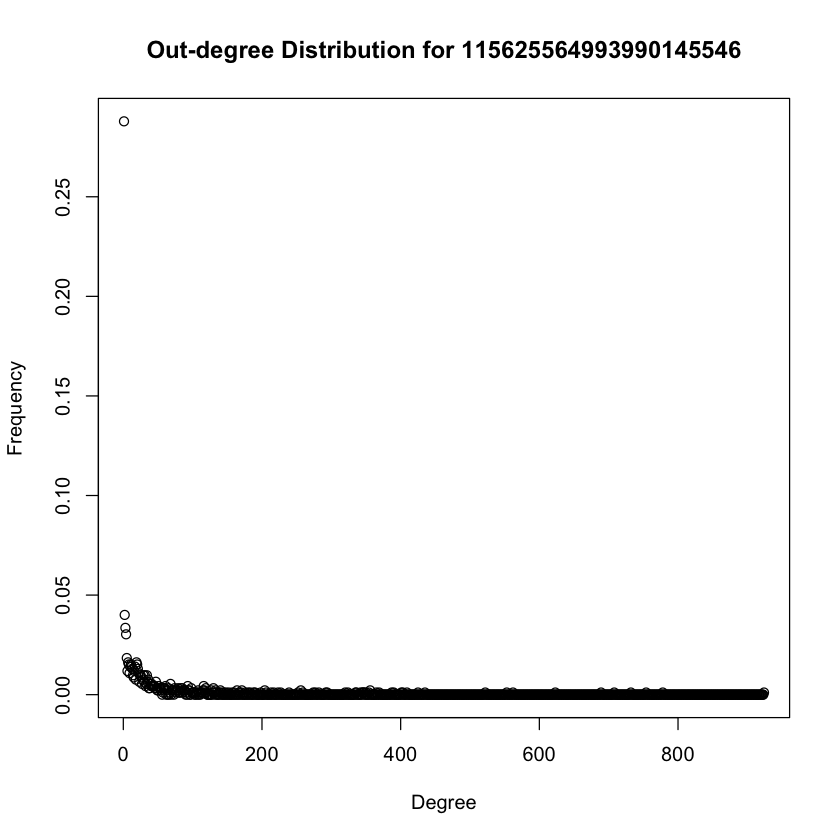

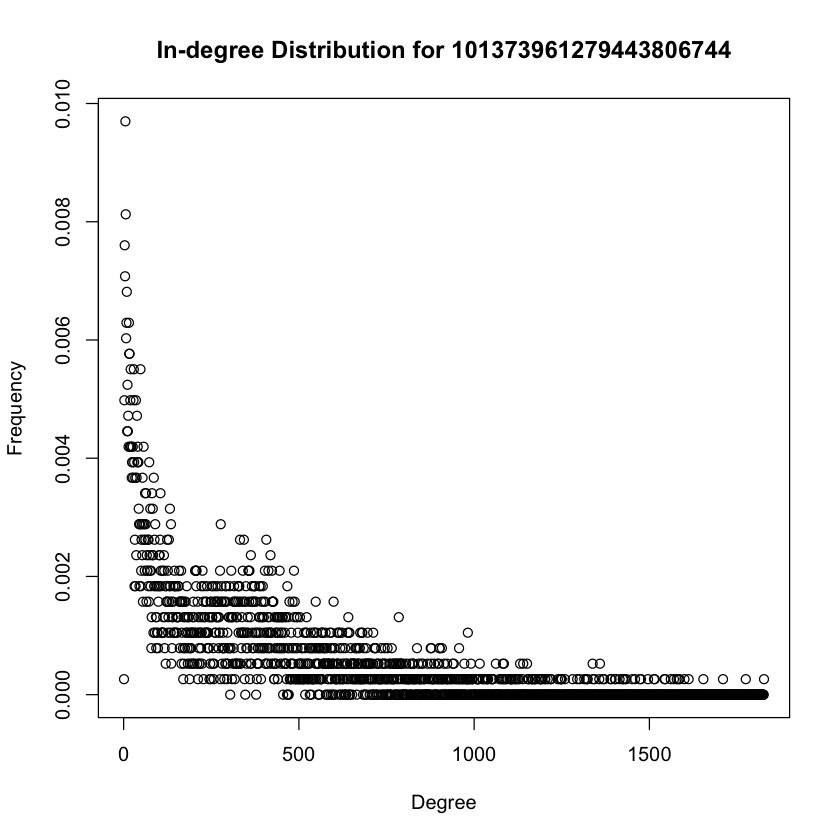

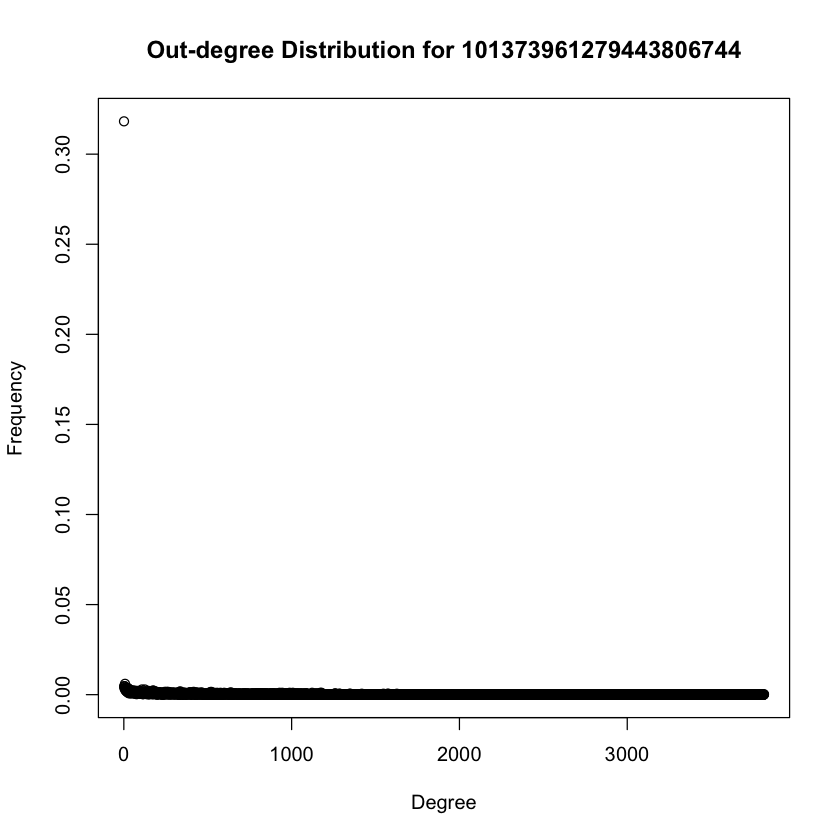

In [4]:
# Load Data From gplus

# Read All Files in gplus
files <- list.files(path = "./gplus")

# Get All Vertices Id
node_ids <- unique(gsub("\\..*", "", files));
n_egos <- length(node_ids);
print(paste("Total Number of Ego Nodes is", n_egos))


# Find Nodes with More Than 2 circles
num_nodes_with_g2_circles <- 0

for (file in files) {
    node_and_type <- unlist(strsplit(x=file, split="[.]", fixed=FALSE))
    if (length(node_and_type) < 2) {
        next
    }
    suffix <- node_and_type[2]
    if (strcmpi(s1=suffix, s2="circles")) {
        circleNum <- length(readLines(paste("./gplus/", file, sep="")))
        if (circleNum > 2) {
            num_nodes_with_g2_circles <- num_nodes_with_g2_circles + 1
        }
    }
}
print(paste("Number of Nodes with more than 2 circles is", num_nodes_with_g2_circles))

# Create Graph with Selected-id
selected_ids <- c('109327480479767108490', '115625564993990145546', '101373961279443806744')
networks <- vector(mode="list", length=3)
for (i in c(1,2,3)) {
    networks[[i]] <- createNetwork(selected_ids[i])
    plot(degree.distribution(networks[[i]], mode="in"), 
         main=paste("In-degree Distribution for", selected_ids[i]),
         xlab="Degree", ylab="Frequency")
    plot(degree.distribution(networks[[i]], mode="out"),
         main=paste("Out-degree Distribution for", selected_ids[i]),
         xlab="Degree", ylab="Frequency")
}


## 2.1 Community structure of personal networks

In [ ]:
# Question20 Modularity Scores and Community Plots
for(i in c(1,2,3)) {
    graph <- networks[[i]]
    community <- cluster_walktrap(graph)
    graph.modularity = modularity(community)
    print(paste("The Modularity for", selected_ids[i], "is", graph.modularity))
    plot(community, graph, edge.color = "black",vertex.label=NA, 
         vertex.size=5, edge.arrow.size=.2,
         main=paste("Community Structure for ", selected_ids[i]))
}


[1] "The Modularity for 109327480479767108490 is 0.252765387296677"
[1] "The Modularity for 115625564993990145546 is 0.319472551345825"


In [18]:
# Question 22 Homogeneity and Completeness 
for (i in seq(1,3)) {
    communities <- cluster_walktrap(networks[[i]])
    h_c <- compute_HC(selected_ids[i], communities) 
    print(paste("For Node", selected_ids[i], ":"))
    print(paste("Homogeneity h =", h_c[1]))
    print(paste("Completeness c =", h_c[2]))
}


[1] "For Node 109327480479767108490 :"
[1] "Homogeneity h = 0.851885115440867"
[1] "Completeness c = 0.329873913536689"
[1] "For Node 115625564993990145546 :"
[1] "Homogeneity h = 0.451890303032235"
[1] "Completeness c = -3.4239623491117"
[1] "For Node 101373961279443806744 :"
[1] "Homogeneity h = 0.0038667069813052"
[1] "Completeness c = -1.5042383879479"


In [5]:
# ONLY FOR TEST PURPOSE
# circleFile <- scan(file=paste("./gplus/", selected_ids[3], ".circles",sep=""), what="", sep="\n");
# circles <- strsplit(circleFile, "[[:space:]]+");
# names(circles) <- sapply(circles, function(x) x[[1]]);
# circles <- lapply(circles, function(x) x[-1]);
# print(length(unique(unlist(circles))))
# intersection <- intersect(as.character(names(V(networks[[2]])))
#                   ,as.character(unique(unlist(circles))))
# community <- cluster_walktrap(networks[[3]])
# membership <- membership(community)
# intersection <- intersect(names(membership), as.character(unique(unlist(circles))))
# sub_membership <- membership[intersection] 
# intersection <- lapply(groups(community), function(x) intersect(x, unique(unlist(circles))))
# sizes <- (sapply(intersection, function(x) length(x)))
# print(sum(sizes))
                 
#     withCircle_membership <- total_membership[unique(unlist(circles))] # nodes with circle info
#     community_nodeNum <- as.data.frame(table(withCircle_membership)) # node community and number
#     circle_node_indices <- c()
#     # This loop is to convert node community from character to numeric
#     for (i in summary[[1]]) {
#         circle_node_indices <- c(circle_node_indices, as.numeric(i))
#     }
#         # bj
#     circle_community_sizes <- vector(mode="integer", length=length(community))
#     circle_community_sizes[circle_node_indices] <- summary[[2]] 